![](Rydiqule_Logo_Transparent_300.png)

# RF heterodyne with Doppler Example

This notebook demonstrates two-tone detection using a Rydberg sensor in the time domain with Doppler averaging.  An RF local oscillator (LO) and signal (sig) are imposed on the Rydberg sensor.  This is useful for RF phase detection, and can be used to linearize the detection, as shown below.  The main results of this example showing how different levels of Doppler averaging affect the beat signal size of the sensor. 

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/RF_Heterodyne_Doppler.ipynb).

In [1]:
import datetime
##***LAST UPDATE***##
now = datetime.datetime.now()
print(now)

2026-01-20 09:34:52.435245


## Imports

In [2]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt

## Define the Sensors

In [3]:
atom = "Rb85"
(g, e) = rq.D2_states(atom)
r1 = rq.A_QState(150, 2, 2.5)
r2 = rq.A_QState(149, 3, 3.5)

In [4]:
rf_rabi = 100 #Mrad/s
red_laser = {'states':(g,e), 'rabi_frequency':2*np.pi*5}  #fields are stored as dictioniaries
blue_laser = {'states':(e,r1), 'rabi_frequency':2*np.pi*7, 'detuning': 0}
LO_ss = {'states':(r1,r2), 'rabi_frequency':rf_rabi, 'detuning':0}


RbSensor_ss = rq.Cell(atom, [g, e, r1, r2],
                      gamma_transit=2*np.pi*1, cell_length = 0.01)
RbSensor_time = rq.Cell(atom, [g, e, r1, r2],
                      gamma_transit=2*np.pi*1, cell_length = 0.01)

In [5]:
state1 = RbSensor_time.states[2]
state2 = RbSensor_time.states[3]
print("1: ", state1)
print("2: ", state1)
dipoleMoment = RbSensor_time.atom.get_dipole_matrix_element(state1,state2, 0)

field = rf_rabi/rq.scale_dipole(dipoleMoment)

print("applied field, V/m:", field) #V/m
print("Rabi frequency, Mrad/s: ", field*rq.scale_dipole(dipoleMoment))

1:  (150, 2, 2.5)
2:  (150, 2, 2.5)
applied field, V/m: 0.09799930011573187
Rabi frequency, Mrad/s:  100.0


In [6]:
def sig_and_LO( delta, beta):
    def fun(t):
        return (1+beta*np.sin(delta*t))
    return fun

In [7]:
rf_freq = RbSensor_time.atom.arc_atom.getTransitionFrequency(*r1[:3],*r2[:3])*1E-6
rf_freq #MHz


658.5872654159832

## Observe a heterodyne beat between the Signal and LO.

### Define the RF LO and signal

In [8]:
sampleNum = 200
endTime = 10 # microseconds
rf = sig_and_LO( 5, .1)

### Solve without Doppler averaging ###

Observe the beat between signal and LO fields.

In [9]:
red_laser = {'states':(g,e), 'rabi_frequency':2*np.pi*5, 'detuning':0}
blue_laser = {'states':(e,r1), 'rabi_frequency':2*np.pi*7, 'detuning': 0}
rf = {'states':(r1,r2), "rabi_frequency": rf_rabi, 'detuning': 0, 'time_dependence': sig_and_LO( 2*np.pi, .05)}

RbSensor_time.add_couplings(blue_laser, red_laser, rf)


In [10]:
#Solve Without any doppler broadening

time_sol = rq.solve_time(RbSensor_time, endTime, sampleNum, atol=1e-6, rtol=1e-6)

In [11]:
transmission = time_sol.get_transmission_coef()

Text(0.5, 1.0, 'Doppler-Free Solution')

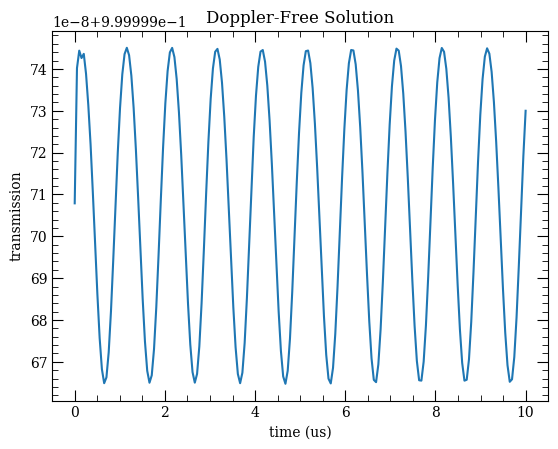

In [12]:
fig, ax = plt.subplots()
ax.plot(time_sol.t, transmission)
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission')
ax.set_title("Doppler-Free Solution")

### Solve with Doppler averaging ###

Doppler averaged results require larger Rabi frequencies to observe similar sized signals.

In [13]:
red_laser = {'states':(g,e), 'rabi_frequency':2*np.pi*5, 'detuning':0, 'kunit': np.array([1,0,0])}
blue_laser = {'states':(e,r1), 'rabi_frequency':2*np.pi*7, 'detuning': 0,'kunit': np.array([-1,0,0])}
rf = {'states':(r1,r2), "rabi_frequency":rf_rabi, 'detuning': 0, 'time_dependence': sig_and_LO( 2*np.pi, .05)}

RbSensor_time.add_couplings(blue_laser, red_laser, rf)

In [14]:
#Solve with a doppler peak calculated from physical system properties
sampleNum = 200
endTime = 10
time_sol_doppler = rq.solve_time(RbSensor_time, endTime, sampleNum, doppler=True, rtol = 1e-6, atol = 1e-6)

In [15]:
transmission_doppler = time_sol_doppler.get_transmission_coef()

Text(0.5, 1.0, 'Doppler Solution')

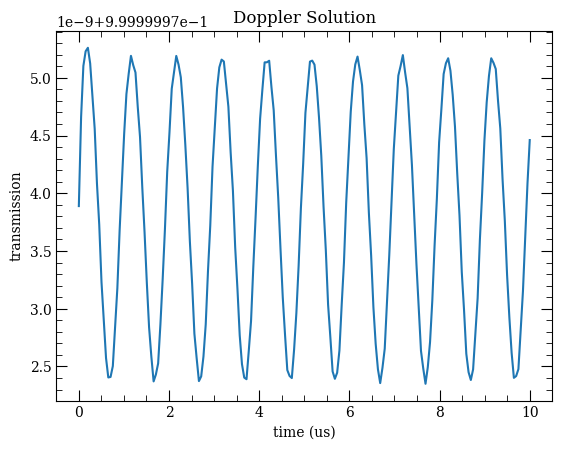

In [16]:
fig, ax = plt.subplots()
ax.plot(time_sol_doppler.t, transmission_doppler)
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission')
ax.set_title("Doppler Solution")

### Compare the size of the beat signals

Here we ignore the starting transient, and normalize the beat signal. As the Doppler broadening is increased, the size of the beat is reduced (for the same optical depth).

In [26]:
def normalize_trace(trace,expand=1):
    ave = trace[100:].mean()
    return (trace - ave)/ave*expand

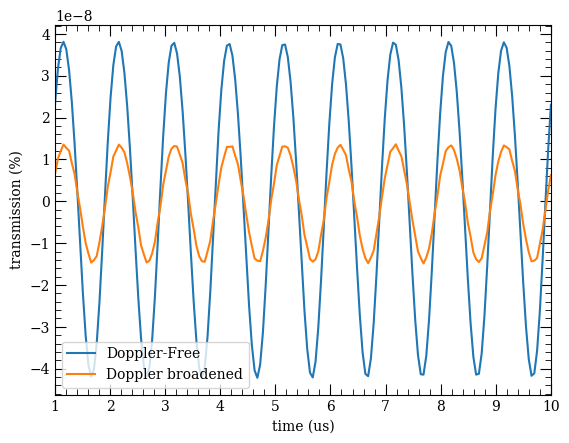

In [29]:
fig, ax = plt.subplots()

ax.plot(time_sol.t, normalize_trace(transmission), label='Doppler-Free')
ax.plot(time_sol_doppler.t, normalize_trace(transmission_doppler,10), label='Doppler broadened')
ax.set_xlim((1,10))
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission (%)')
ax.legend()

In [30]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.2.0.dev48+g6f06f9960.d20260120
Installation Path:    ~\src\rydiqule_public\src\rydiqule

      Dependencies
    
NumPy Version:        2.2.6
SciPy Version:        1.15.3
Matplotlib Version:   3.10.8
ARC Version:          3.9.0
Python Version:       3.10.19
Python Install Path:  ~\src\rydiqule_public\.venv\Scripts
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB
